# Introduction

As humans we perceive videos using objects and their interactions. This is an attempt to use that same principle to recognize videos.

# Imports

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import skvideo.io
%matplotlib inline
sys.path.append("..")
from utils import label_map_util
from utils import visualization_utils as vis_util
import seaborn as sns

# Open the frozen model

In [2]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90

In [3]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

# Create Label Maps

In [4]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Helper functions

In [5]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [6]:
def frameCountError(reader,n):
    # get total number of frames in the video
    T = reader.getShape()[0]
    # give error if n>T
    if n>T:
        reader.close()
        raise ValueError("n should be less than or equal to %i, the total number frames in the video"%T)

In [7]:
def getFrame(video,n):
    """
        returns the n th frame of the video
        this is slow.
        Only use for debugging
    """
    reader = skvideo.io.FFmpegReader(video)
    frameCountError(reader,n)
    counter = 1
    for frame in reader.nextFrame():
        if counter == n:
            reader.close()
            return frame
        counter+=1

# Video Recognition

From SSD what's important is, `boxes`, `scores`, `classes` and `num_detections`. Let's define a function that outputs those.

In [8]:
def getParams(image_np):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
    return (boxes, scores, classes, num_detections)

# Load Videos

In [9]:
drive   = "/media/amila/prank/"
adPath  = drive+"Ads/seperate trims/"
path    = drive+'GitHub/videoRecog/videoRecog/videoRecog/'
vidPath = drive+"Users/ASUS/Documents/Adobe/Premiere Pro/9.0/"

ads    = [adPath+"ADD_%i.mp4"%i for i in range(1,9,1)]                 # ads small size
g_ads  = [path+"g_ad_%i.mp4"%i for i in range(1,9,1)]                  # Gamma-corrected ads
vids   = [vidPath+"ad%i.mp4"%i for i in range(1,9,1)]                  # ads original size
nVids  = [path+"nVid%i.mp4"%i for i in range(1,9,1)]                   # sigma = 5
nVids2 = [path+"nVid2_%i.mp4"%i for i in range(1,9,1)]                 # sigma = 20
nVids3 = [path+"nVids3_%i.mp4"%i for i in range(1,9,1)]                # sigma = 1

# Visualize Detection

In [10]:
def showDetection(vid,n):
    frame1=getFrame(vid,n)
    b,s,c,n=getParams(frame1)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      frame1,
      np.squeeze(b),
      np.squeeze(c).astype(np.int32),
      np.squeeze(s),
      category_index,
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(frame1)
    plt.show()

# Hash

`genHash1` and `genHash2` are two different hash generating functions. `genHash1` takes `score` values into account although `genHash2` doesn't. They both give following parameters for a given frame:

1. `class`
2. `cx`,`cy` - coordinates of the center of mass of detected object
3. `score`

... for at most 5 objects detected.

`saveHash` saves the hash for n frames using hash generating function as an `.npy` file. The loaded `.npy` file has a `(25,5,4)` shape.

In [11]:
def genHash1(frame):
    """This function generates the hash for the given frame thresholding a probability"""
    global sess
    hash_ = []
    with tf.Session(graph=detection_graph) as sess:
        b,s,c,n=getParams(frame)
    # get the index marker for objects with score>0.5
        marker = 0
        b = b.squeeze()
        s = s.squeeze()
        c = c.squeeze()
        while marker<5:
            if s[marker]>0.5:
                x1,y1,x2,y2 = b[marker]
                cx,cy = (x1+x2)/2,(y1+y2)/2
                hash_.append((c[marker],cx,cy,s[marker]))
            else:
                hash_.append(None)
            marker += 1
    return hash_

In [12]:
def genHash2(frame):
    """This function generates the hash for the given frame without thresholding a probability"""
    global sess
    hash_ = []
    with tf.Session(graph=detection_graph) as sess:
        b,s,c,n=getParams(frame)
    # get the index marker for objects with score>0.5
        marker = 0
        b = b.squeeze()
        s = s.squeeze()
        c = c.squeeze()
        while marker<5:
            x1,y1,x2,y2 = b[marker]
            cx,cy = (x1+x2)/2,(y1+y2)/2
            hash_.append((c[marker],cx,cy,s[marker]))
            
            marker += 1
    return hash_

In [13]:
def saveHash(vid,fileName,n,hashGenFunc):
    """saves the hash of the frames of vid to fileName
    """
    reader = skvideo.io.FFmpegReader(vid)
    frameCountError(reader,n+1)
    toWrite = []
    for i in range(n):
        toWrite.append(hashGenFunc(reader._readFrame()))
    reader.close()
    np.save(fileName,np.array(toWrite))

Import hash files that were previously compiled for 1st 25 frames of videos. `genHash1` was used only for `vids_genHash1_hashes` just to see how it behaves.

In [14]:
vids_genHash1_hashes   = ['vids_%i.npy'%i for i in range(8)]
vids_genHash2_hashes   = ['vids_%i_genHash2.npy'%i for i in range(8)]
nVids_genHash2_hashes  = ['nvids_%i_genHash2.npy'%i for i in range(8)]
nVids2_genHash2_hashes = ['nvids2_%i_genHash2.npy'%i for i in range(8)]
nVids3_genHash2_hashes = ['nvids3_%i_genHash2.npy'%i for i in range(8)]
ads_genHash2_hashes    = ['ads_%i_genHash2.npy'%i for i in range(8)]
g_ads_genHash2_hashes  = ['g_adds_%i_genHash2.npy'%i for i in range(8)]

In [15]:
hashList = [vids_genHash1_hashes, 
            vids_genHash2_hashes, 
            nVids_genHash2_hashes,
            nVids2_genHash2_hashes,
            nVids3_genHash2_hashes,
            ads_genHash2_hashes,
            g_ads_genHash2_hashes]

Let's compare the `class` plane of `ads_genHash2_hashes` and `g_ads_genHash2_hashes`.

In [16]:
np.load(ads_genHash2_hashes[0]).shape

(25, 5, 4)

In [17]:
# class_plane_ads_0_genHash2
a = np.load(ads_genHash2_hashes[0])[:,:,0]
# class_plane_g_ads_0_genHash2
b = np.load(g_ads_genHash2_hashes[0])[:,:,0]

In [18]:
a;

In [19]:
b;

Not good. Let's see how many points are matching out of 125 points ($25\times 5$)

In [20]:
matchPoints = (a==b)
np.sum(matchPoints)

41

# Evaluation on `score`

Let's see the `score` values @ `matchPoints`.

In [21]:
# score_plane_ads_0_genHash2
a_s = np.load(ads_genHash2_hashes[0])[:,:,-1]
# score_plane_g_ads_0_genHash2
b_s = np.load(g_ads_genHash2_hashes[0])[:,:,-1]

In [22]:
a_s_matching = matchPoints*a_s
b_s_matching = matchPoints*b_s
a_s_mismatching = (~matchPoints)*a_s
b_s_mismatching = (~matchPoints)*b_s

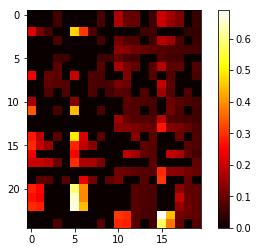

In [23]:
s_matching = np.concatenate(
    (a_s_matching,
     b_s_matching,
     a_s_mismatching,
     b_s_mismatching),axis=1)
matchMap = plt.imshow(s_matching,'hot')
plt.colorbar(matchMap)
plt.show()

The vertical axis corresponds to frame and the horizontal to top 5 `score`s. Higher the intensity, higher the `score`.

Let's check the average `score` values @ `matchPoints` and `~matchPoints`

In [24]:
np.sum(a_s_matching)/np.sum(matchPoints)

0.1499114613525751

In [25]:
np.sum(a_s_mismatching)/np.sum(~matchPoints)

0.10022536917988743

There's not much difference between the  average score values. It's no wonder because, the video we check (`ads[0]`) does not have enough `class`es defined in the `ssd_mobilenet_v1_coco_11_06_2017` model or if some `class` was there in the video, the `score` is low. 

Let's see the distribution of the 'score' values which will be helpful for us to get an idea of **how useful the current model for the video is.** 

For 25 frames we have 5 `score`s for each frame, altogether 125 scores for 25 frames.  

In [26]:
def scoreHist(hash_file):
    """This will draw the histogram of scores """
    # extract scoreplane and reshape
    S = np.load(hash_file)[:,:,3].flatten()
    sns.distplot(S)
    plt.title(hash_file)
    plt.show()

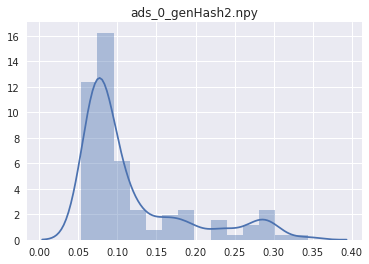

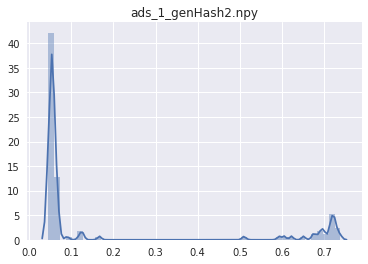

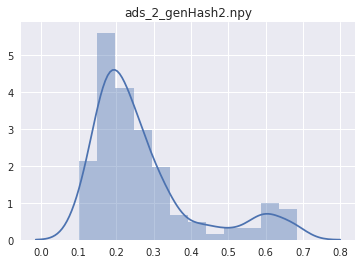

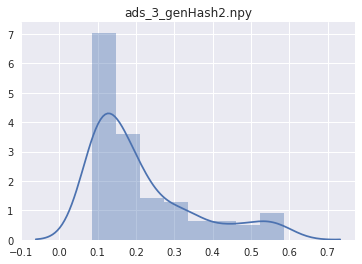

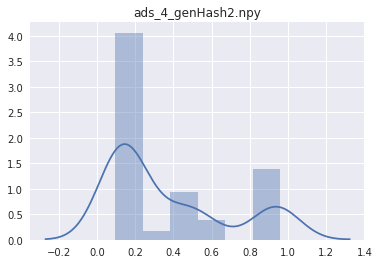

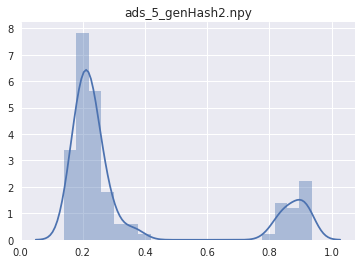

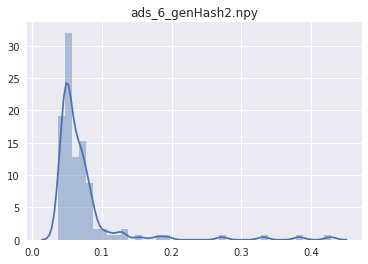

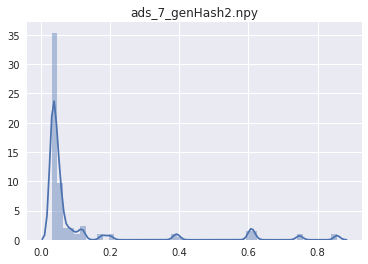

In [27]:
for hash_file in hashList[5]:
    scoreHist(hash_file)

Most of the `scores` are around zero. That depicts the choice of `class`es in the model is not good enough for this scenario.

What we observed above were the best 5 `score`s for a frame into 25 frames. Now let's consider only the best `score`.

In [27]:
def scoreBestHist(hash_file):
    """This will draw the histogram of scores """
    # extract scoreplane and reshape
    S = np.load(hash_file)[:,0,3].flatten()
    sns.distplot(S)
    plt.title(hash_file)
    plt.show()

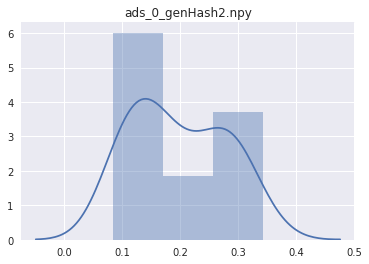

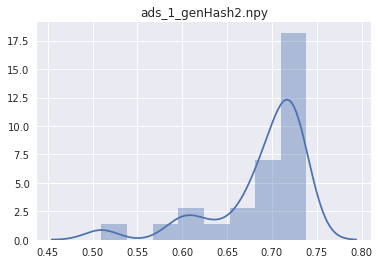

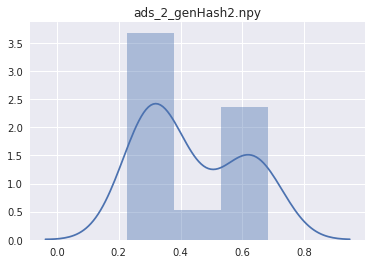

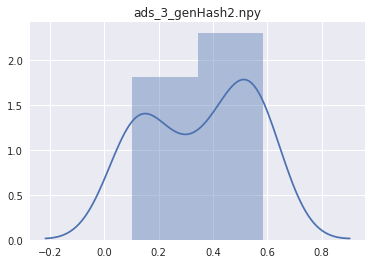

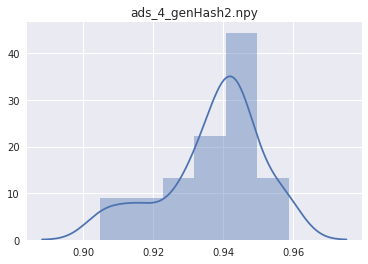

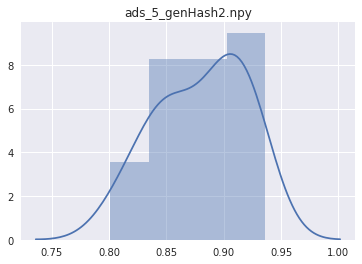

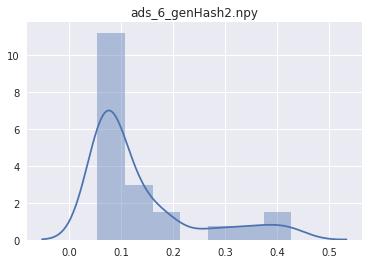

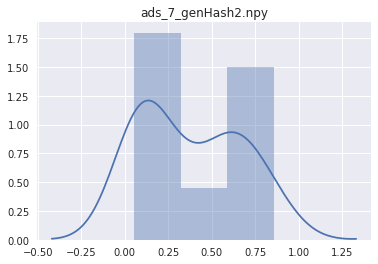

In [29]:
for hash_file in hashList[5]:
    scoreBestHist(hash_file)

For most of the videos, majority of the best `score` is around 1 which is a good sign. 

Let's look at how the difference between the distribution of `score`s between corresponding video pairs.

In [28]:
def scoreBestHist(hash_files,labels):
    """This will draw the histogram of scores """
    # extract scoreplane and reshape
    for hash_file,label in zip(hash_files,labels):
        S = np.load(hash_file)[:,0,3].flatten()
        sns.distplot(S,label=label)
    plt.legend()
    plt.title(hash_files[0])
    plt.show()

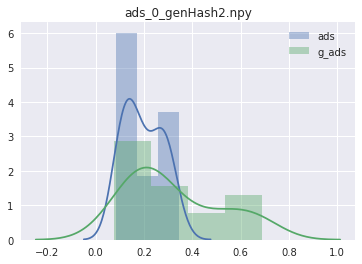

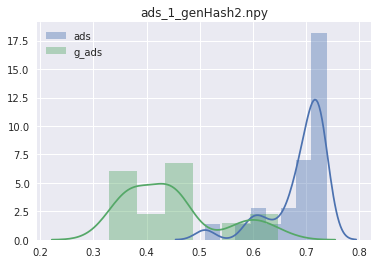

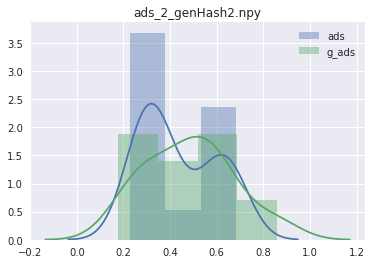

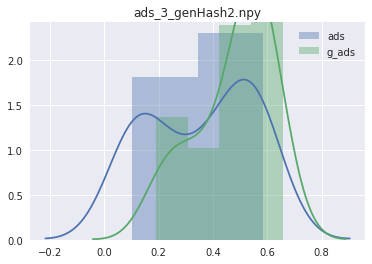

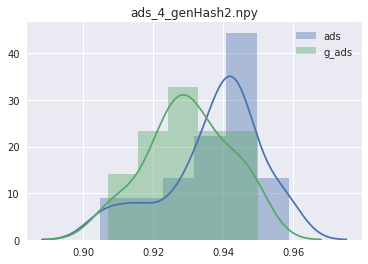

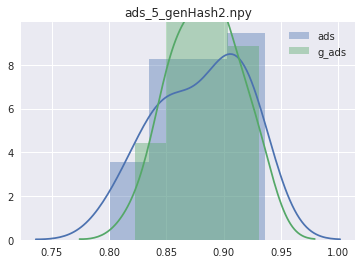

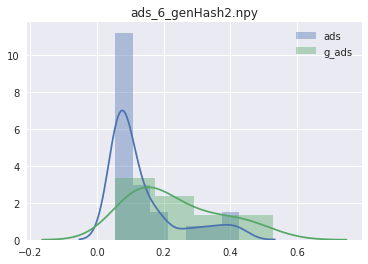

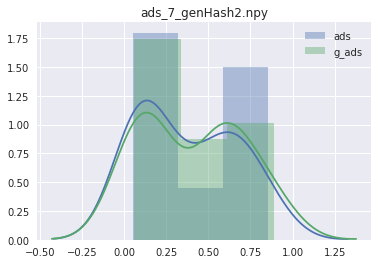

In [29]:
sns.set(color_codes=1)
for hash_file1,hash_file2 in zip(hashList[5],hashList[6]):
    scoreBestHist((hash_file1,hash_file2),['ads','g_ads'])

# Quality

Most of the time reduction of quality is an artifact that could happen in a video. This reduction can be simulate using `ffmpeg`. 

Note that when `quality_level` value increases actual **quality** decreases and artifacts such as pixeleration occurs. Lower the value, more closer to the original video.

In [30]:
quality_levels = [10,20,30,40,50,60]

In [ ]:
for quality_level in quality_levels:
    !mkdir "$vidPath/lowqlty/$quality_level"
    for vid in vids:
        vidName = vid[-7:]
        !ffmpeg -i "$vid" \
        -sws_flags lanczos+accurate_rnd \
        -crf $quality_level \
        -preset veryfast \
        -profile:v main \
        -tune fastdecode \
        -c:a copy "$vidPath/lowqlty/$quality_level/$vidName"

Now we have to generate hash for those videos. Better if we have seperate folder for saving hashes.

In [31]:
vidNames = np.array(['/ad%i'%i for i in range(1,9,1)],dtype=object)
lowQPath = vidPath+'lowqlty/'

In [32]:
!mkdir -p hashes/lowqlty

In [ ]:
for quality_level in quality_levels:
    !mkdir -p hashes/lowqlty/$quality_level/test
    LQVids = lowQPath+str(quality_level)+vidNames
    for LQVid in LQVids:
        saveHash(LQVid+'.mp4',
                 'hashes/lowqlty/'+str(quality_level)+'/'+LQVid[-3:]+'.npy',
                 25,
                 genHash2)

In [33]:
pathPrefixes = ['hashes/lowqlty/%i/'%i for i in range(10,70,10)]

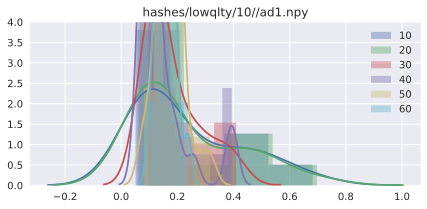

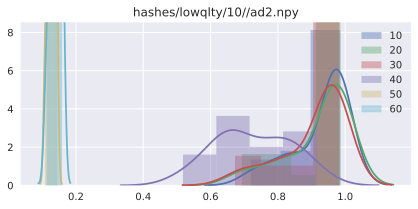

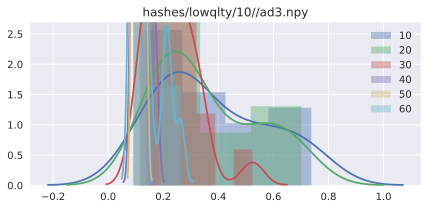

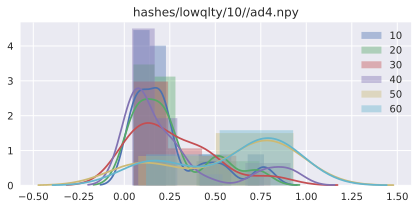

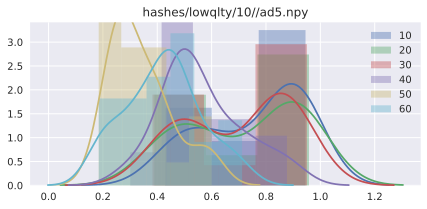

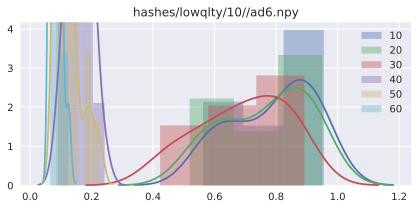

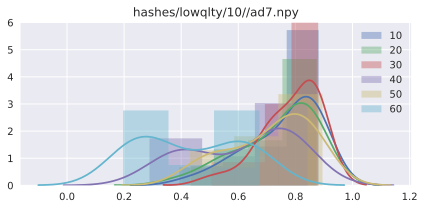

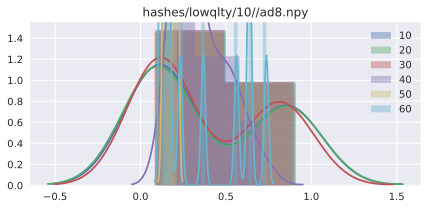

In [48]:
%config InlineBackend.figure_format = 'svg'
for vidName in vidNames:
    plt.figure(figsize=(7,3))
    pp=np.array(pathPrefixes,dtype=object)+vidName+'.npy'
    scoreBestHist(pp,map(str,quality_levels))

This is how distribution of `score` deforms with respect to `quality_level`. Closer the `quality_level`, closer the distribution.

Let's add newly created hashes to the `hashList`.

In [35]:
hashList = hashList + [[pathPrefixes[j]+vidNames[i]+'.npy' for i in range(8)] for j in range(6) ]

In [36]:
a_s_matching;

In [37]:
a_s_mismatching;

Let's look @ the location of the objects @ `matchPoints`.

In [38]:
# location_plane_ads_0_genHash2
a_l = np.load(ads_genHash2_hashes[0])[:,:,1:3]
# location_plane_g_ads_0_genHash2
b_l = np.load(g_ads_genHash2_hashes[0])[:,:,1:3]

In [39]:
a_l_matching = np.dstack((matchPoints,matchPoints))*a_l
b_l_matching = np.dstack((matchPoints,matchPoints))*b_l

Take the cartesian distances between those matching locations.

In [40]:
matchPoints.T[0,:]

array([False, False,  True, False, False, False, False,  True, False,
       False,  True,  True, False, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False, False], dtype=bool)

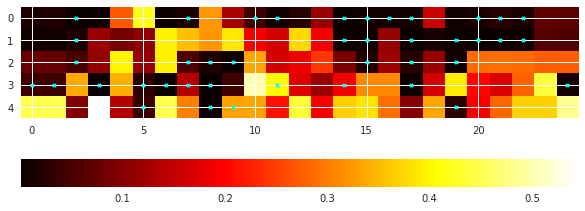

In [41]:
X_a = a_l[:,:,0]
X_b = b_l[:,:,0]
Y_a = a_l[:,:,1]
Y_b = b_l[:,:,1]
distance = np.sqrt((X_a-X_b)**2+(Y_a-Y_b)**2)
fig, ax = plt.subplots(figsize=(10,5))
heatMap = ax.imshow(distance.T,'hot')
x = np.argwhere(matchPoints)[:,0]
y = np.argwhere(matchPoints)[:,1]
heatMap2 = ax.scatter(x,y,marker='x',color = 'cyan',s=10)
plt.colorbar(heatMap,orientation='horizontal')
plt.show()

Most of the darker points (closer objects) are in `matchPoints`(<font color='cyan' >x</font>), which is a good sign.

In [42]:
distance_matching = np.copy(distance)
distance_matching[~matchPoints]=0
distance_mismatching = np.copy(distance)
distance_mismatching[matchPoints]=0
distance_matching_avg = np.sum(distance_matching)/np.sum(matchPoints)
distance_mismatching_avg = np.sum(distance_mismatching)/np.sum(~matchPoints)

In [43]:
distance_matching_avg

0.040347675816978332

In [44]:
distance_mismatching_avg

0.22635136754567739

This is good sign. But it's better to check `distance_matching_avg` and `distance_mismatching_avg` pairs for other 7 pairs of `ads` and `g_ads`.

But we have to remember that there are only 41 matching points out of **125**.

Let's make a function to get the `distance` pair for a pair of videos.

In [45]:
def getdist(vid1_hash,vid2_hash):
    """vid1_hash/vid2_hash: file name of the saved hash
       outputs dist_matching_avg,dist_mismatch_avg
       in addition show the heatmap with matchPoints marked
    """
    # class_plane_ads_0_genHash2
    a = np.load(vid1_hash)[:,:,0]
    # class_plane_g_ads_0_genHash2
    b = np.load(vid2_hash)[:,:,0]
    matchPoints = (a==b)
    # location_plane_ads_0_genHash2
    a_l = np.load(vid1_hash)[:,:,1:3]
    # location_plane_g_ads_0_genHash2
    b_l = np.load(vid2_hash)[:,:,1:3]
    X_a = a_l[:,:,0]
    X_b = b_l[:,:,0]
    Y_a = a_l[:,:,1]
    Y_b = b_l[:,:,1]
    distance = np.sqrt((X_a-X_b)**2+(Y_a-Y_b)**2)
    
    fig, ax = plt.subplots(figsize=(10,5))
    heatMap = ax.imshow(distance.T,'hot')
    x = np.argwhere(matchPoints)[:,0]
    y = np.argwhere(matchPoints)[:,1]
    heatMap2 = ax.scatter(x,y,marker='x',color = 'cyan',s=10)
    plt.colorbar(heatMap,orientation='horizontal')
    plt.show()
    
    distance_matching = np.copy(distance)
    distance_matching[~matchPoints]=0
    distance_mismatching = np.copy(distance)
    distance_mismatching[matchPoints]=0
    distance_matching_avg = np.sum(distance_matching)/np.sum(matchPoints)
    distance_mismatching_avg = np.sum(distance_mismatching)/np.sum(~matchPoints)
    return distance_matching_avg,distance_mismatching_avg

Check for `ads` and `g_ads`.

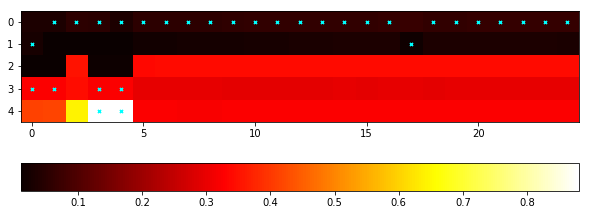

1 distance_matching_avg =  0.144435798379 distance_mismatching_avg =  0.236326589423


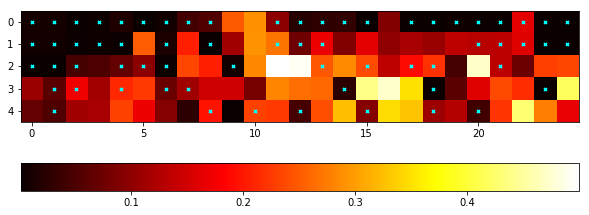

2 distance_matching_avg =  0.0658288534207 distance_mismatching_avg =  0.212746348923


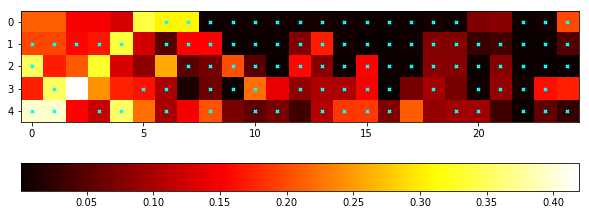

3 distance_matching_avg =  0.0908314636763 distance_mismatching_avg =  0.158916106342


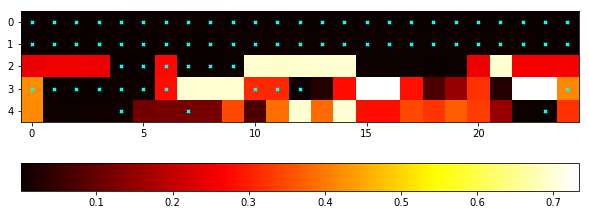

4 distance_matching_avg =  0.0330579320021 distance_mismatching_avg =  0.332081962735


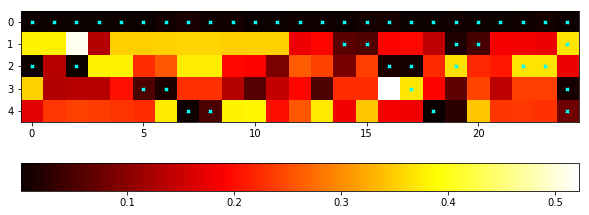

5 distance_matching_avg =  0.0534118289549 distance_mismatching_avg =  0.241303811291


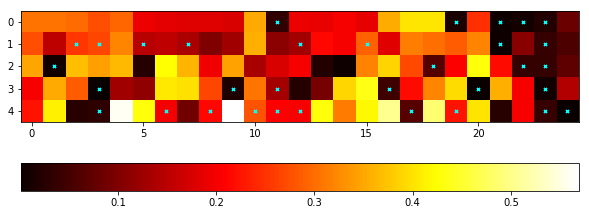

6 distance_matching_avg =  0.0967879366901 distance_mismatching_avg =  0.260689142077


In [41]:
for i in range(1,7,1):
    v1, v2 = hashList[5][i], hashList[6][i]
    m, mm = getdist(v1,v2)
    print i,'distance_matching_avg = ',m,'distance_mismatching_avg = ',mm

>**Remarks:** Looks fine
>
> distance_matching_avg < distance_mismatching_avg

Check for `vids` and `nvids` ($\sigma=5$).

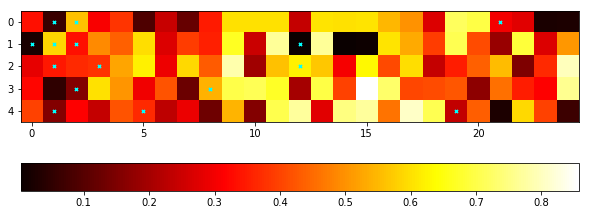

0 distance_matching_avg =  0.312489737598 distance_mismatching_avg =  0.438727767415


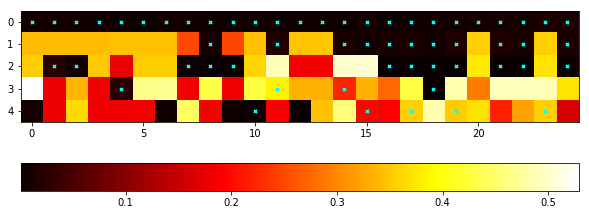

1 distance_matching_avg =  0.0404209189425 distance_mismatching_avg =  0.315324358152


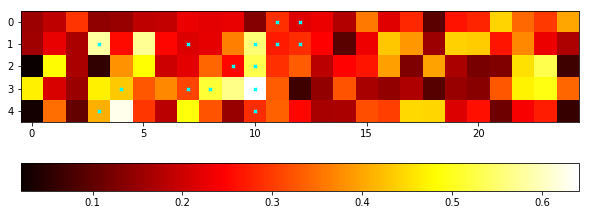

2 distance_matching_avg =  0.3864679601 distance_mismatching_avg =  0.267245714107


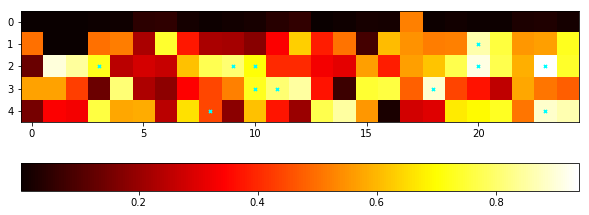

3 distance_matching_avg =  0.791175412246 distance_mismatching_avg =  0.379269958114


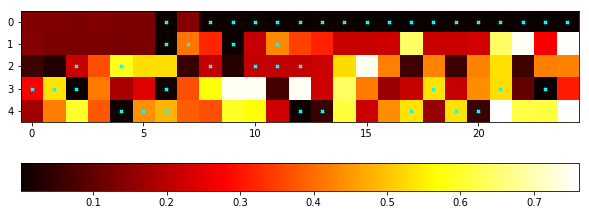

4 distance_matching_avg =  0.153057752186 distance_mismatching_avg =  0.341543755655


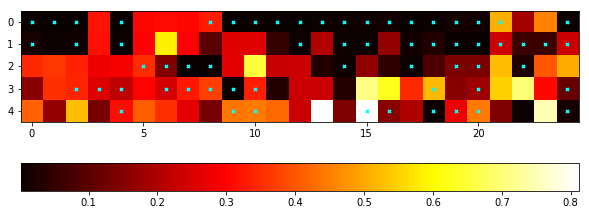

5 distance_matching_avg =  0.133624075913 distance_mismatching_avg =  0.302367246974


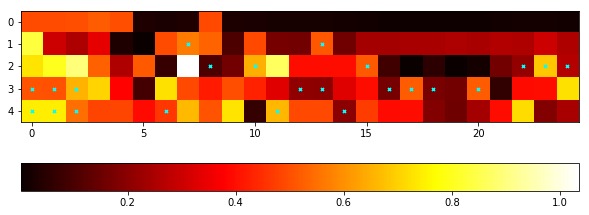

6 distance_matching_avg =  0.449662715978 distance_mismatching_avg =  0.3093322806


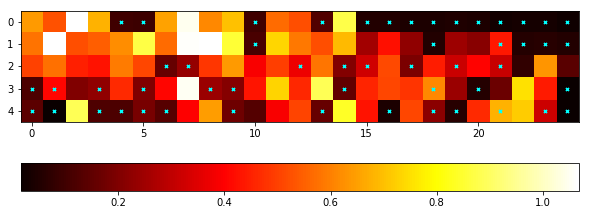

7 distance_matching_avg =  0.16272911267 distance_mismatching_avg =  0.56303964008


In [42]:
for i in range(8):
    v1, v2 = hashList[1][i], hashList[2][i]
    m, mm = getdist(v1,v2)
    print i,'distance_matching_avg = ',m,'distance_mismatching_avg = ',mm

> **Remarks**: Not Good
>
> `np.sum(matchPoints)` very low $\Rightarrow$ less importance of `distance_avg` pair

Check for `vids` and `nvids2` ($\sigma=1$).

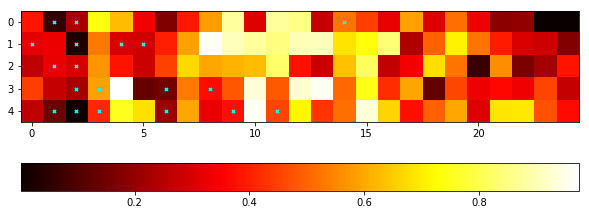

0 distance_matching_avg =  0.28098852817 distance_mismatching_avg =  0.511866440651


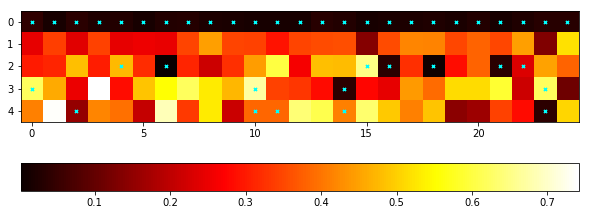

1 distance_matching_avg =  0.132485771851 distance_mismatching_avg =  0.38419799259


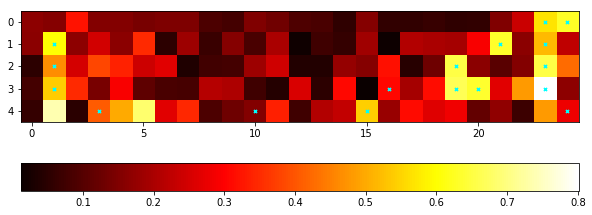

2 distance_matching_avg =  0.533570431483 distance_mismatching_avg =  0.182683715265


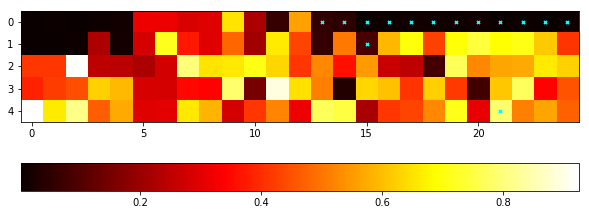

3 distance_matching_avg =  0.0774957031761 distance_mismatching_avg =  0.443867962088


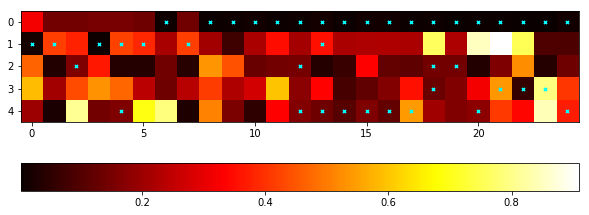

4 distance_matching_avg =  0.150268431131 distance_mismatching_avg =  0.284978159325


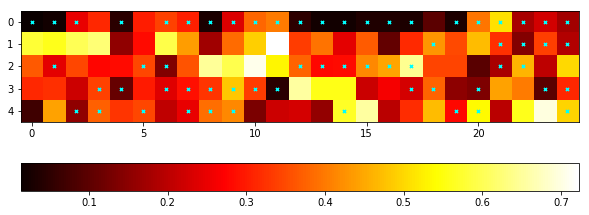

5 distance_matching_avg =  0.264811975783 distance_mismatching_avg =  0.372432285053


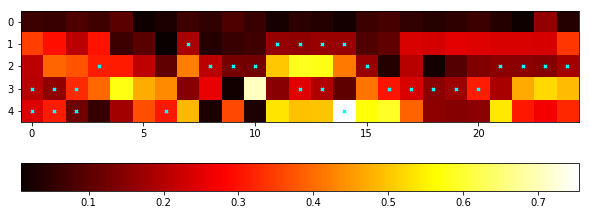

6 distance_matching_avg =  0.223795014419 distance_mismatching_avg =  0.225528744446


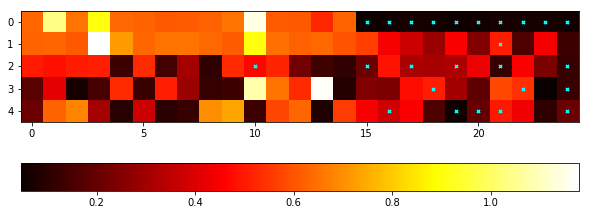

7 distance_matching_avg =  0.208874192608 distance_mismatching_avg =  0.464413305303


In [43]:
for i in range(8):
    v1, v2 = hashList[1][i], hashList[3][i]
    m, mm = getdist(v1,v2)
    print i,'distance_matching_avg = ',m,'distance_mismatching_avg = ',mm

> **Remarks:** Better than above
>
> Same observation on `np.sum(matchPoints)` (Exception `i=3`)

Check for `vids` and `nVids3` ($\sigma=20$) 😉

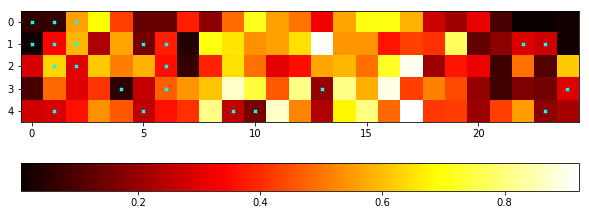

0 distance_matching_avg =  0.281691047734 distance_mismatching_avg =  0.445327078809


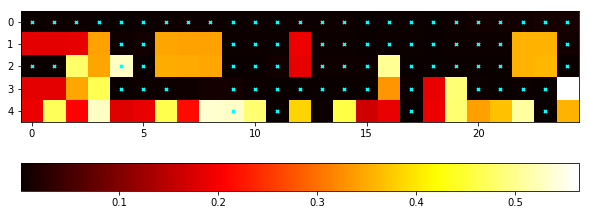

1 distance_matching_avg =  0.017732575563 distance_mismatching_avg =  0.31594908565


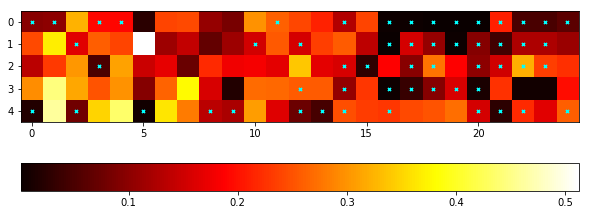

2 distance_matching_avg =  0.11337734634 distance_mismatching_avg =  0.226170186143


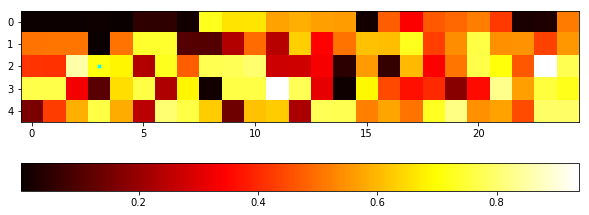

3 distance_matching_avg =  0.713815534041 distance_mismatching_avg =  0.485824604646


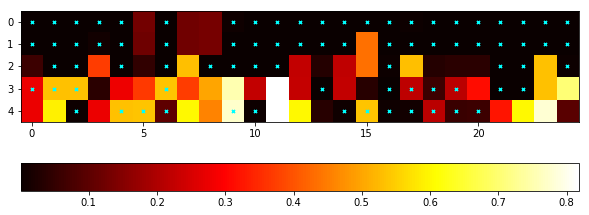

4 distance_matching_avg =  0.0680029407447 distance_mismatching_avg =  0.330199736227


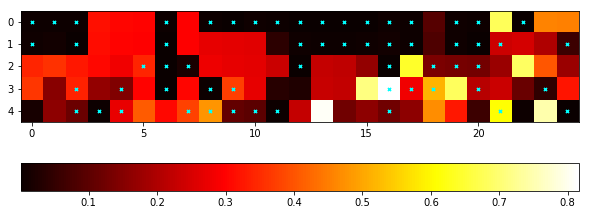

5 distance_matching_avg =  0.104566238653 distance_mismatching_avg =  0.288413790717


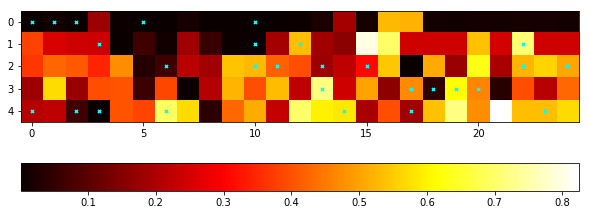

6 distance_matching_avg =  0.308840500542 distance_mismatching_avg =  0.283873600898


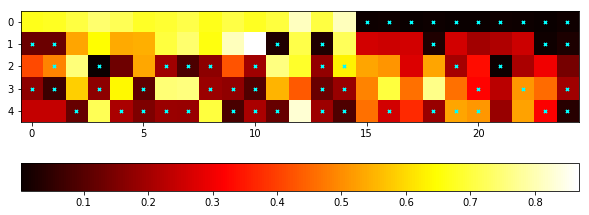

7 distance_matching_avg =  0.152151465927 distance_mismatching_avg =  0.542383188324


In [44]:
for i in range(8):
    v1, v2 = hashList[1][i], hashList[4][i]
    m, mm = getdist(v1,v2)
    print i,'distance_matching_avg = ',m,'distance_mismatching_avg = ',mm

> **Remarks** Some have almost 0 `matchPoints` (`i=3`) Some have more `matchPonits` than that of less noisy versions! Is it a pure coincidence or..?

Let's incorporate `scores` as well to our scope.

Define a function that will show the product of `score`s.

In [46]:
def getScoreProduct(vid1_hash,vid2_hash):
    """vid1_hash/vid2_hash: file name of the saved hash
       outputs dist_matching_avg,dist_mismatch_avg
       in addition show the heatmap with matchPoints marked
    """
    # class_plane_vid1_hash
    a = np.load(vid1_hash)[:,:,0]
    # class_plane_vid2_hash
    b = np.load(vid2_hash)[:,:,0]
    matchPoints = (a==b)
    # score_plane_vid1_hash
    a_s = np.load(vid1_hash)[:,:,3]
    # score_plane_vid2_hash
    b_s = np.load(vid2_hash)[:,:,3]
    # product of scores 
    P_s = a_s*b_s
    
    fig, ax = plt.subplots(figsize=(10,5))
    heatMap = ax.imshow(P_s.T,'hot')
    x = np.argwhere(matchPoints)[:,0]
    y = np.argwhere(matchPoints)[:,1]
    heatMap2 = ax.scatter(x,y,marker='x',color = 'cyan',s=10)
    ax.grid(0)
    plt.colorbar(heatMap,orientation='horizontal')
    plt.show()
    return P_s

Check for `ads` and `g_ads`

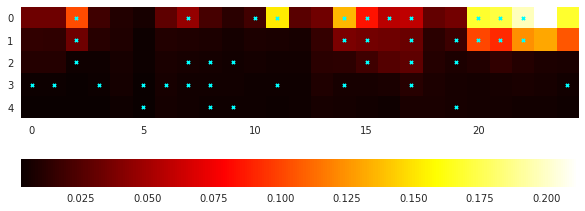

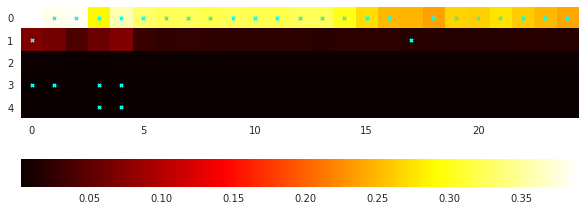

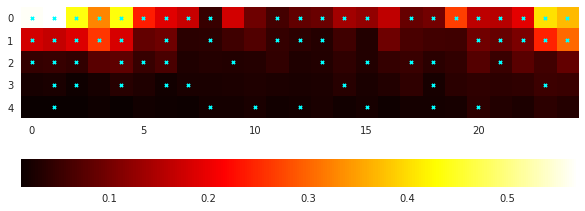

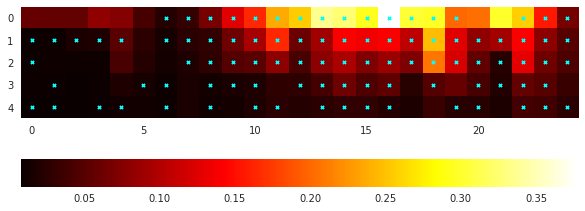

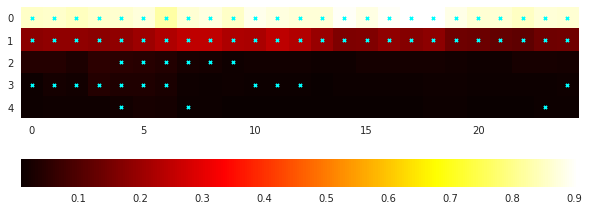

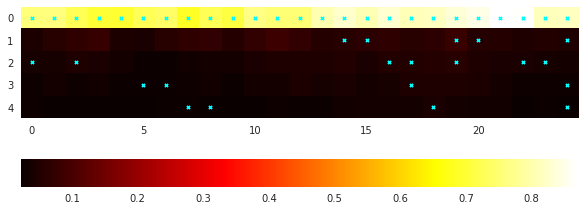

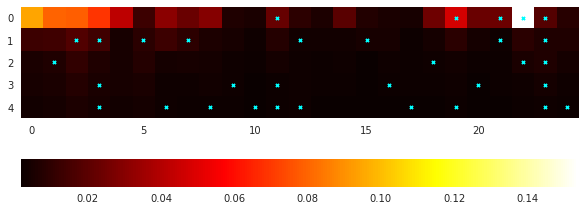

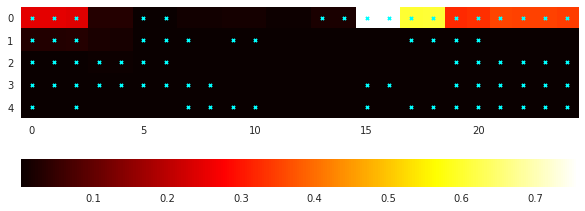

In [58]:
for i in range(8):
    v1, v2 = hashList[6][i], hashList[5][i]
    getScoreProduct(v1,v2)

As we saw earlier majority of the `scores` are very low, which makes the product of score even lower. If we look the first row of each heatmap, where there are higher score product tend to be a `matchPoint`. But those points may not be enough to make a sound decision. Let's check this scenario for some other pairs.

Check for `vids` with `quality_level` 10 vs `vids` with `quality_level` 20.

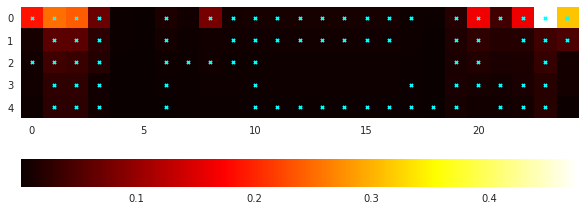

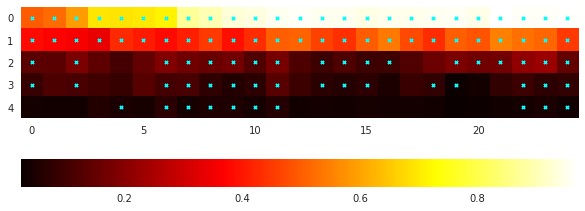

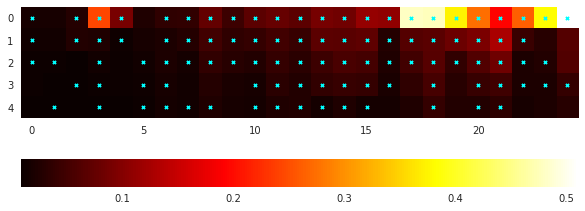

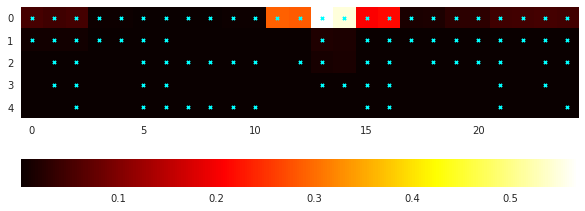

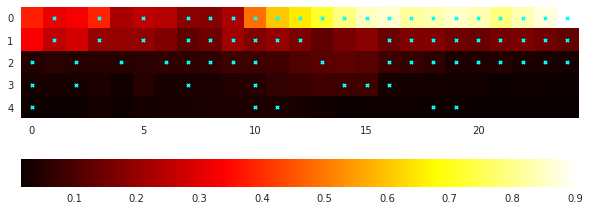

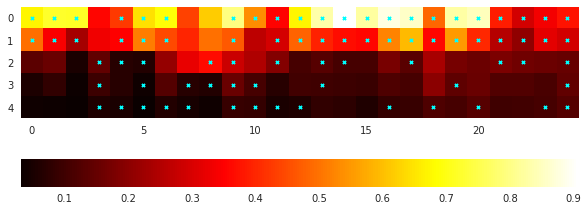

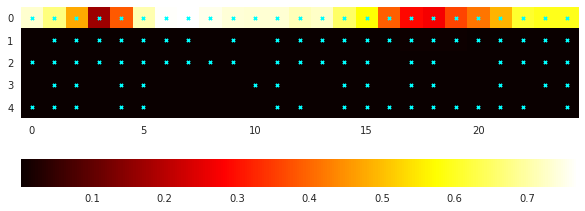

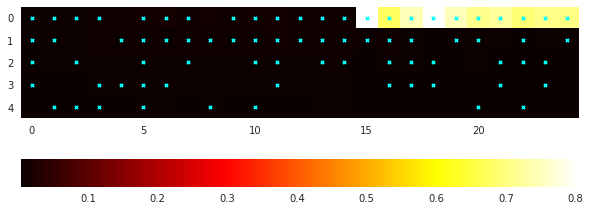

In [60]:
for i in range(8):
    v1, v2 = hashList[7][i], hashList[8][i]
    getScoreProduct(v1,v2)

Although the pairs have a lot of `matchPoints`, the case for the product of `score`s is the same as before and there's no a visible relationship beween the `matchPoints` and product of `score`s.